In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, roc_curve, roc_auc_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing the data 
df = pd.read_csv("HR_comma_sep.csv")

In [3]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
df.shape

(14999, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [6]:
df.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

### We can see that there are no null values in our dataset.

## EDA

In [9]:
# Numeric Features
numeric = pd.DataFrame()
cat = pd.DataFrame()
for i in df.describe(include = 'number').columns:
    numeric[i] = df[i]
# Catgorical Features
for i in df.describe(exclude = 'number').columns:
    cat[i] = df[i]

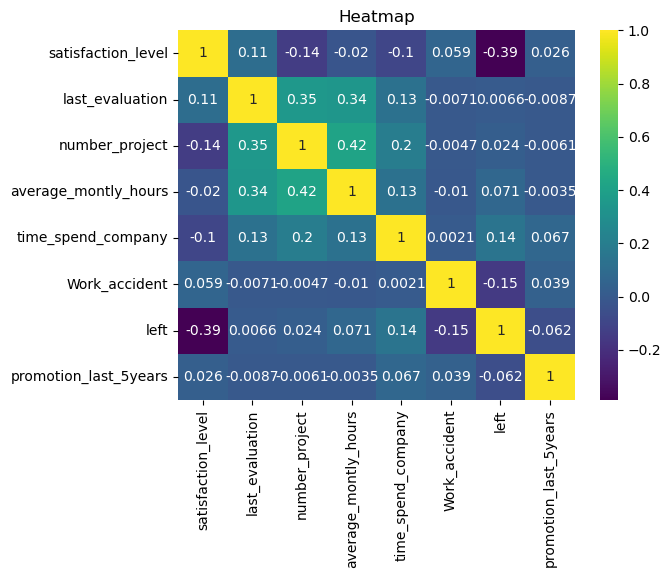

In [10]:
# Heatmap of correlation Matrix
corr = numeric.corr()
sns.heatmap(corr,annot = True, cmap = 'viridis')
plt.title("Heatmap")
plt.show()

### As no feature is correlated above 0.7 so no feature will be dropped. 

In [12]:
# Distribution Plot 
def displt(i):
    sns.displot(df[i], kde  = True)
    plt.xlabel(i)
    plt.ylabel("EmployeeCount")
    plt.title(f"Distribution Plot of {i}")
    plt.show()

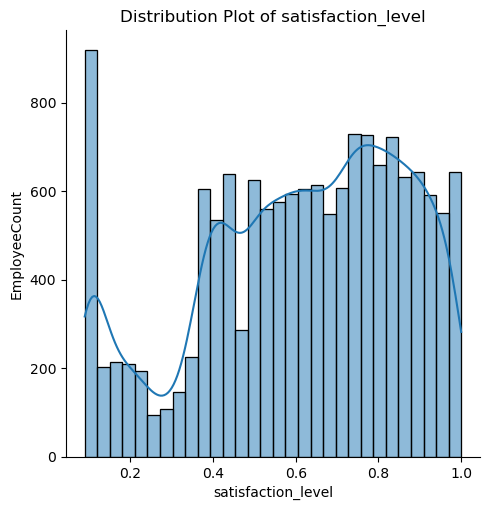

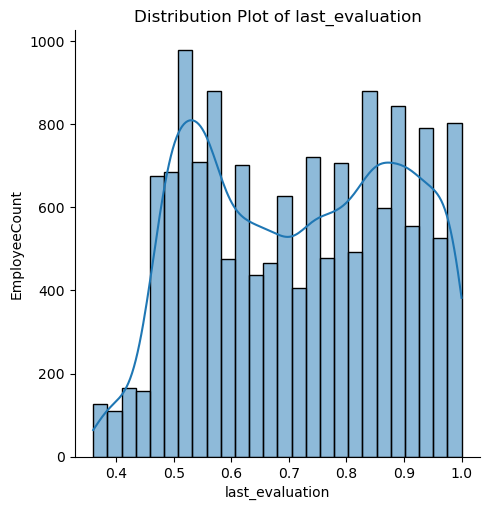

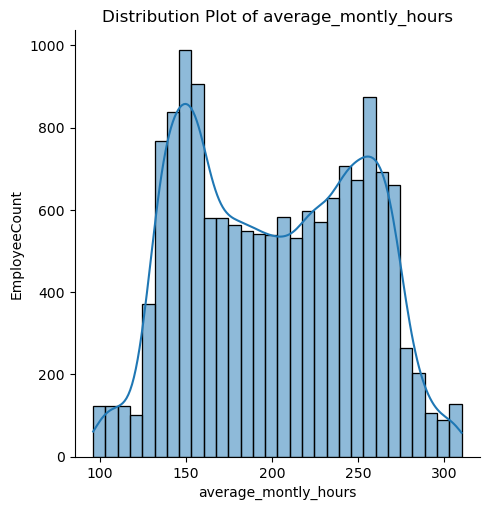

In [13]:
displt("satisfaction_level")
displt("last_evaluation")
displt("average_montly_hours")

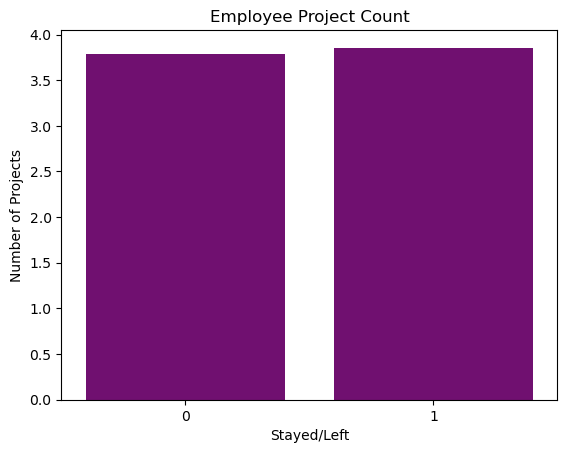

In [14]:
#barplot
left = df[df["left"] == 1]
stay = df[df["left"] == 0]
sns.barplot(y = df["number_project"],x = df["left"],errorbar = None, color = 'purple')
plt.xlabel("Stayed/Left")
plt.ylabel("Number of Projects")
plt.title("Employee Project Count")
plt.show()


In [16]:
df1 = df[df["left"] == 1]
X = df1[["satisfaction_level","last_evaluation"]]

In [17]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)
kmeans = KMeans(n_clusters = 3,random_state = 123)
clusters=kmeans.fit_predict(X_sc)

In [18]:
df1["cluster"] = clusters

In [19]:
cluster_summary = df1.groupby('cluster')[['satisfaction_level', 'last_evaluation']].mean()
print(cluster_summary)

         satisfaction_level  last_evaluation
cluster                                     
0                  0.111321         0.870884
1                  0.412304         0.517265
2                  0.808031         0.916415


- Cluster 0 shows these employees last evaluation was high but they are no satisfied. This could be because of lack of appreciation and recognition.
- Cluster 1 shows moderate satisfaction level and moderate last evaluation, so these people are less active and motivated towards their job.
- Cluster 2 shows these people are highly motivated and satisfied with their job, so they must be given long term career incentives. 

In [21]:
left_dict = df["left"].value_counts()

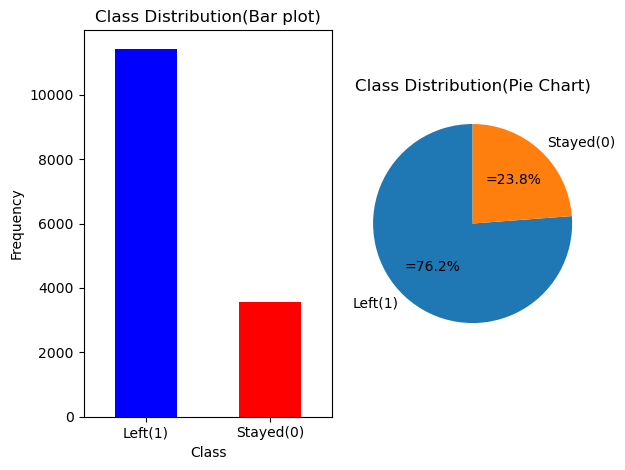

In [22]:
# Plotting the bar plot and pie chart to show left CLass Imbalance
plt.subplot(1,2,1)
left_dict.plot(kind = "bar", color = ["blue","red"])
plt.title("Class Distribution(Bar plot)")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks([0,1],["Left(1)","Stayed(0)"], rotation = 0)

plt.subplot(1,2,2)
left_dict.plot(kind = "pie", color = ["blue","red"],labels = ["Left(1)","Stayed(0)"], autopct = '=%1.1f%%',startangle = 90)
plt.title("Class Distribution(Pie Chart)")
plt.ylabel("")
plt.tight_layout()
plt.show()


In [23]:
# Preprocessing the data 
df_1 = pd.get_dummies(df,columns = ["sales","salary"], drop_first = True,dtype = int)

In [24]:
# Dividing the data
X = df_1.drop(columns =['left'])
y = df_1["left"]

In [25]:
#train and test dataset
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 123)

In [27]:
def model(mod):
    pipeline = Pipeline([
        ("smote", SMOTE(random_state = 123)),
        ("model", mod)
    ])
    y_pred = cross_val_predict(pipeline, X_train, y_train,cv = 5)
    print(f"Classification Report for {mod}")
    print(classification_report(y_train,y_pred))

    model = pipeline.fit(X_train,y_train)
    y_pred_test = model.predict(X_test)    

    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    
    plt.plot(fpr, tpr, color = 'blue', lw =2, label = f'ROC Curve (Area = {roc_auc:.4f})')

    plt.plot([0,1], [0,1], color = 'grey', lw =2, linestyle ='dashed')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Reciever Operating Characterstics ROC Curve - DTC on Imbalanced Data')
    plt.legend(loc = 'lower right')
    plt.show()
    print(f"Confusion Matrix for {mod}")
    print(confusion_matrix(y_test,y_pred_test))

Classification Report for LogisticRegression()
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      9137
           1       0.50      0.76      0.60      2862

    accuracy                           0.76     11999
   macro avg       0.70      0.76      0.72     11999
weighted avg       0.81      0.76      0.77     11999



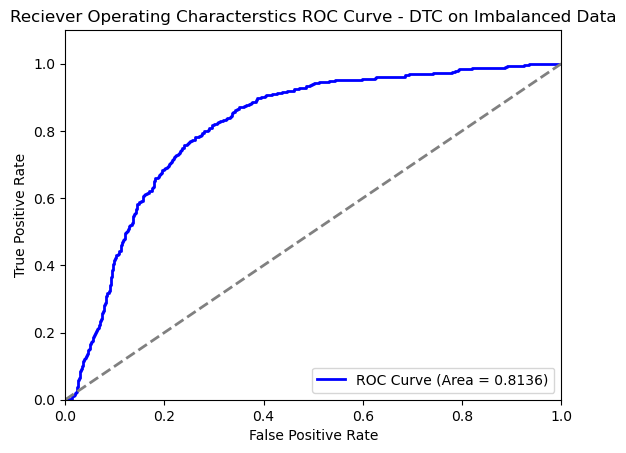

Confusion Matrix for LogisticRegression()
[[1742  549]
 [ 173  536]]


In [28]:
model(LogisticRegression())

Classification Report for RandomForestClassifier()
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9137
           1       0.98      0.97      0.97      2862

    accuracy                           0.99     11999
   macro avg       0.98      0.98      0.98     11999
weighted avg       0.99      0.99      0.99     11999



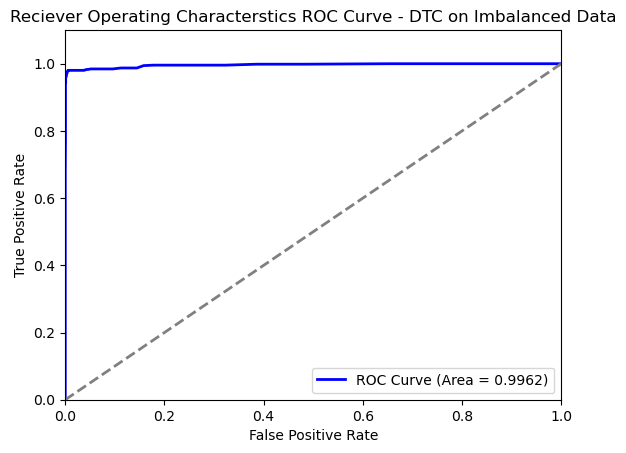

Confusion Matrix for RandomForestClassifier()
[[2279   12]
 [  15  694]]


In [29]:
model(RandomForestClassifier())

Classification Report for GradientBoostingClassifier()
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      9137
           1       0.92      0.94      0.93      2862

    accuracy                           0.96     11999
   macro avg       0.95      0.96      0.95     11999
weighted avg       0.97      0.96      0.97     11999



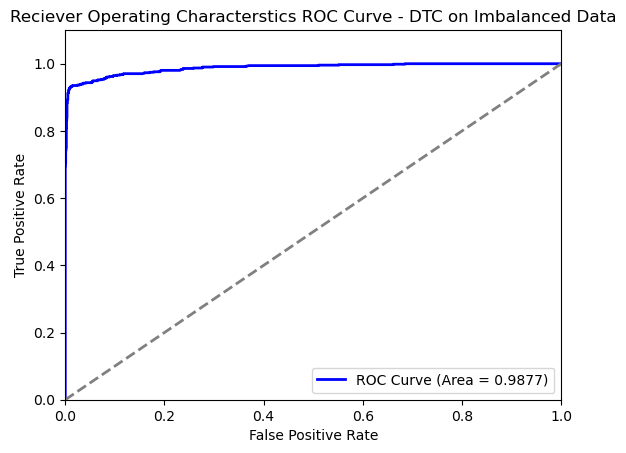

Confusion Matrix for GradientBoostingClassifier()
[[2224   67]
 [  45  664]]


In [30]:
model(GradientBoostingClassifier())

### The best model here is the RandomFroestClassifier because of the highest ROC Curve Area that shows the model has a high Recall. Our main objective is to get a high recall from confusion in such problems because we can't afford False Negatives. Predicting someone will not leave and the person leaves will cost the organisation

In [32]:
# Predicting the probability Turnover using the best model 
pipeline = Pipeline([
    ("smote", SMOTE(random_state = 123)),
    ("model", RandomForestClassifier())
])
model = pipeline.fit(X_train,y_train)
score = model.predict_proba(X_test)
Category = pd.DataFrame({
    "Score":score[:,1]*100
})

In [33]:
ranges = [-0.1,20,60,90,100]
Zones = ["Green","Yellow","Orange","Red"]
Category["Zone"] = pd.cut(Category["Score"],bins = ranges, labels = Zones)

In [34]:
Category

,Score,Zone
0,6.0,Green
1,2.0,Green
2,0.0,Green
3,13.0,Green
4,1.0,Green
...,...,...
2995,100.0,Red
2996,2.0,Green
2997,100.0,Red
2998,1.0,Green


### Retention Strategies
- For Green, there must be appreciation and a special employee bonus.
- For Yellow, incentives should be given as increasing their salary, reducing workload etc.
- For Orange, the workload must be reduced, and see if any promotions or special packages available to retain them.
- For Red, new replacements should be on time, so the company suffers no loss due to sudden absence of an employee.